In [1]:
import pandas as pd
import numpy as np

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn
warnings.simplefilter('ignore')

import sys
sys.path.extend(['../src/'])

from config import *

import matplotlib.pyplot as plt
import seaborn as sns

from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

% matplotlib inline

config = Config()

os.listdir(config.origin_data_filepath)

['.ipynb_checkpoints',
 '2015-2018维修数据_部分.xlsx',
 '2017维修数据.xlsx',
 '2018维修数据.xlsx',
 'sources',
 'Untitled.ipynb']

In [9]:
data = {}
for file in ['2015-2018维修数据_部分.xlsx', '2017维修数据.xlsx', '2018维修数据.xlsx']:
    data[file] = pd.read_excel('{}{}'.format(config.origin_data_filepath, file))

In [11]:
data_ = pd.concat(data).reset_index(drop = True)[data['2015-2018维修数据_部分.xlsx'].columns]

### 重要信息列的缺失

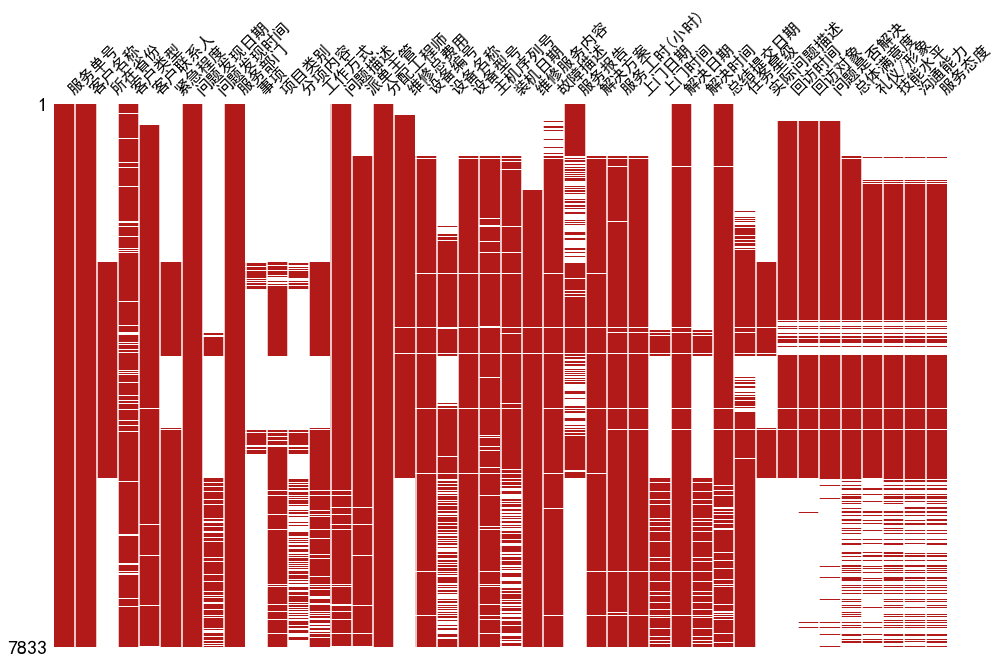

In [17]:
import missingno as msno
msno.matrix(data_,figsize=(16, 10),color=(0.7, 0.1, 0.1),filter='bottom',sparkline=False)
plt.savefig('{}NA_origin_eda.png'.format(config.savefig_path))

根据方案的设计，

### 文本列的处理

由于文本的问题描述和服务报告使用html语言保存的

&nbsp; 在 html里是空格占位符
<br> 是空标签
\n 是回车换行符

需要使用正则化剔除掉这些特殊字符

In [37]:
import re

def text_clean(content):
    try:
#         result = re.sub(r'[^\u4e00-\u9fa5,A-Za-z0-9]', " ",content)
        result = re.sub('&nbsp;', "",content)
        result = re.sub('<br>', "",result)
#         result = re.sub('正常', " ",result)
        result = re.sub('\n', "",result)
    except:
        result = ''
    return result

In [37]:
for i in range(100):
    print(text_clean(data['问题描述'][i]))

1235仪器偶尔提示TipInAir。
偶尔17-OHP实验提示TipInAir4331
Lis与Leica软件对接问题。
FISH扫描对焦失败。
双标实验F点偏高，400万以上；筛查阳性率低于平时，只有2%-3%；
GSL120黑屏重启，显卡温度高。GSL120年度保养。
1、加样针误报clot，不多，每次实验一两个，但客户不接受；2、洗板机头容易堵（我今天过去检查）
1235产筛实验结果，标准品第四点异常，diff偏差超过50%。
GSP性能检测。
近期第二次发生找不到增强液的报错已安排杨露鉴去检查
1235产筛实验，标准品D点偏低，同时，质控中值也偏低，样本中，只要是4号针加样的样本，都有偏低的倾向，因此需要检查加样针的加样精度。（已安排潘盛过去）
1、洗板机堵孔，昨日多次清洁后正常，今天又堵，清洁无效2、最近两次实验高值质控低出控，第一次原因不明，第二次确认为质控复融问题，科室希望做仪器维护排除仪器问题（1个月前已做年度维护，后更换滤光片和导轨）
杭州市妇产科医院2号1235仪器，联机报错，1号针注射器工作异常
客户反映GSL120加油针不灵活；1235做性能验证，并出具报告；
1.新筛实验有报bloodmissing的报错2.170hp实验缓冲液位置报错tipinair3.实验结果出控，复孔标准品的差异很大.客户希望进行相关性能测试
1235实验过程中突然在去血片过程中出现真空错误，疑似发生严重漏气
近期加样枪两次问题，一次去吸头时的up-downmoversteppingerror，一次去黑帽时的up-downmoversteppingerror，并且提示取不到黑帽；还有长期以来的真空错误
MB8扫描对焦模糊；初步判断为显微镜Z轴磨损，待下周二与奥林帕斯售后仪器上门维修。
KM2明场捕获图像质量不理想，要求调试参数；3台KM系统维护保养；
客户反映最近阳性标本复查重复性下降，cv超过10%的标本增多。需要仪器保养与性能验证。
早孕实验报错“foamdetected”，导致不吸样，加样针涂层损坏严重，需要更换
1235联机报错epprom读取错误，怀疑node1IC14故障需要更换
确认空气过滤器需要更换，销售已报价。
维修洗板机堵，并执行年度维护；
例行执行半年度维护
1235 更换电脑 系统重装软件重装
执行1235半年度维护
执行1235季度维护
G

可以看到问题描述中有很多年度维护，半年度维护，季度维护的描述

In [39]:
data_['问题描述_clean'] = data_['问题描述'].apply(text_clean)

In [41]:
data_['是否定期维护'] = data_['问题描述_clean'].apply(lambda x: '度维护' in x)

可以看到，按照'度维护'关键词提取后，有几种异常情况

1. 存在处理了问题后，进行年度维护的情况
2. 有可能修理的是一台仪器，维护的是另一台仪器

分析的问题在于，如何预测下一次修理可能的时间，定期去维护，维护的主体是仪器还是仪器的部件

In [43]:
data['服务报告_clean'] = data['服务报告'].apply(text_clean)

In [52]:
for i in range(20):
    print(text_clean(data['服务报告'][i]))

1、校准右枪Flag传感器位置；2、对换左右枪；3、待观察
1、校准右枪TipSensor压力；2、移除空气过滤器，真空报错正常；3、待观察；
leica软件生成xml文件，包含病人信息及图像信息；Lis直接调用xml文件内容，实现对接；
1、测试发现客户未调试好曝光时间；2、培训客户调试曝光时间，测试扫描正常；
检查仪器Flash值为1380，反馈滤光片腐蚀；用增强液及无水酒精清洁反馈滤光片；Flash下降至1180；用Eu定标液重新校准FLASH值至1080；测试实验双标F点降低至330万，恢复正常；
问题：GSL120黑屏，怀疑显卡故障，年度维护处理：到场后，客户已更换显卡，电脑能正常工作。根据客户反应，最近一次有一张玻片拍到空白照片。检查后发现仪器光源不稳定，摄像头画面明暗闪烁。询问得知客户最近自行跟换灯泡，检查灯泡发现瓦数不对，正常使用100w的灯泡，客户换上去的是30w换100w灯泡后光源稳定仪器全套校准结果：隔夜扫片正常。
检查确认仪器大概率不存在问题，首先每次实验报clot的数量减少，只有一两个，其次是报错并不集中于某一根针，3次报错分别是三根不同的加样针。进行的操作是检查了加样针的固定和排线的链接，重新校准了液面感应。并对样本上机前处理，同许主任进行了交流。针对浙江等地的经验，即上机前用竹签再挑一下，许主任暂时是抵触的，需要俞勇再去教育一下。客户反应的另一个洗板机头容易堵的情况，检查下来没有发现什么异常，清洁了洗板机头。
对四根加样针进行精度测试：P1=25.33，P2=25.17，P3=25.12，P4=25.23，正常；进行洗板测试，发现部分孔注水不满，吸的时候对应的单数列第四个点吸的水吸不干，残留三分之一左右；实验标准曲线不好是由于洗板机头问题，清洁洗板机头，并指导客户如何清洁；
-washertest正常-MeasurementModuleTest正常-HighVolumePipetteTest正常-LowVolumePipetteTest正常
问题：开机自检报错，机器无法运行；措施：1.查看历史记录，发现实验前未放置稀释杯，导致实验无法往下走2.维护增强液管路，对管路进行疏通，未发现异物结果：1.增强液测试通过；2.开机自检正常；3.跟一次实验正常；
对四根加样针进行精度测试，发现第四根针在加水之后针尖挂水滴；把第四根针与第三根互换，发现

### 客户信息描述

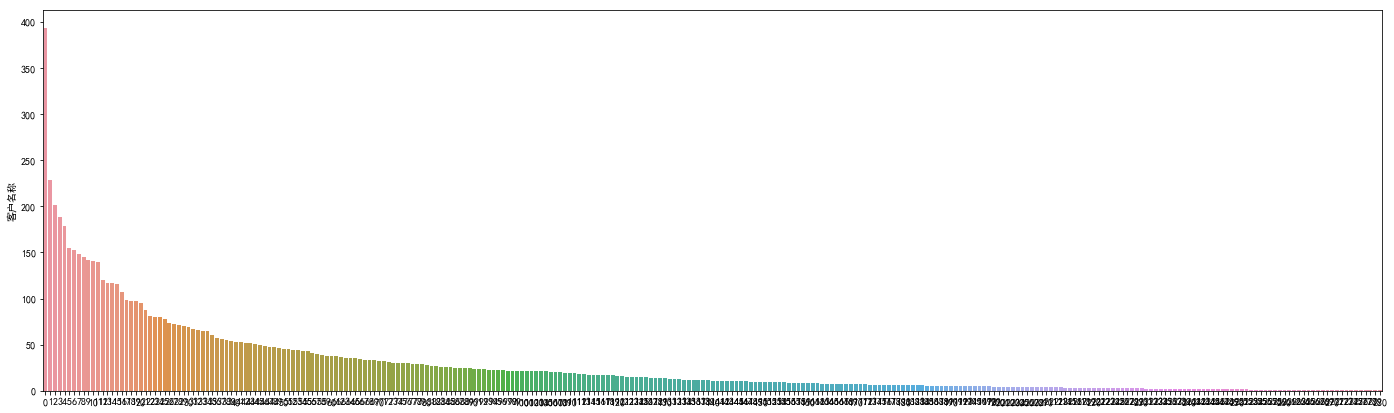

In [32]:
client_eda = data_['客户名称'].value_counts()

plt.figure(figsize = (24,7))
sns.barplot(list(range(len(list(client_eda.index)))), client_eda)
plt.savefig('{}客户统计.png'.format(config.savefig_path))

In [36]:
pd.DataFrame(data_['客户类型'].value_counts())

,客户类型
VIP,2869
V VIP,1932
V+VIP,1286
一般客户,694
V+ VIP,234
其他,50
一般,4
正常,2


In [43]:
data_.loc[data_['是否定期维护'],'客户类型'].value_counts()

VIP       501
V VIP     300
V+VIP     223
一般客户       91
V+ VIP     54
其他          5
一般          3
正常          2
Name: 客户类型, dtype: int64

In [47]:
pd.DataFrame(data_['设备编号'].value_counts())

,设备编号
BS-2014-PKI-AD-06,48
BS-2011-PKI-AD-08,48
BS-2012-LAK-GSL-02,44
BS-2016-PKI-GSP-01,38
BS-2010-PKI-AD-02,37
BS-2013-PKI-AD-01,36
BS-2012-PKI-AD-06,34
BS-2011-PKI-AD-11,31
BS-2016-Aff-SMY-07,31
BS-2009-PKI-AD-03,31


In [49]:
pd.DataFrame(data_['设备型号'].value_counts())

,设备型号
1235-514,1700
GSL-120,675
2021-0010,595
2081-0010,526
GSL-120/GSL-10,413
1235-5220,400
GCS3000DX2,393
1420-020,391
TQD,359
CDS-5,310


In [50]:
pd.DataFrame(data_['设备名称'].value_counts())

,设备名称
全自动时间分辨荧光免疫分析系统,1092
自动扫描显微镜和图像分析系统,530
全自动荧光免疫分析仪(GSP),292
全自动打孔仪,222
微阵列基因芯片分析系统,204
荧光免疫分析仪（1420 VICTOR D Multilable Counter）,154
染色体核型分散仪(CDS-5),137
串联质谱（Xevo TQD）,127
全自动毛细管电泳仪,113
串联质谱（TQD）,109


In [53]:
data_.shape

(7833, 44)

In [33]:
data_.columns

Index(['服务单号', '客户名称', '所在省份', '客户类型', '客户联系人', '紧急程度', '问题发现日期', '问题发现时间',
       '服务部门', '事项 ', '项目类别', '分项内容', '工作方式', '问题描述', '派单主管', '分配工程师', '维修总费用',
       '设备编号', '设备名称', '设备型号', '主机序列号', '装机日期', '维修服务内容', '故障描述', '服务报告',
       '解决方案', '服务工时(小时)', '上门日期', '上门时间', '解决日期', '解决时间', '总结提交日期', '任务星级',
       '实际问题描述', '回访时间', '回访对象', '问题是否解决', '总体满意度', '礼仪/形象', '技能水平', '沟通能力',
       '服务态度'],
      dtype='object')

In [54]:
data = data_.loc[data_['设备编号'].notnull(),:]

In [55]:
data.shape

(6917, 44)

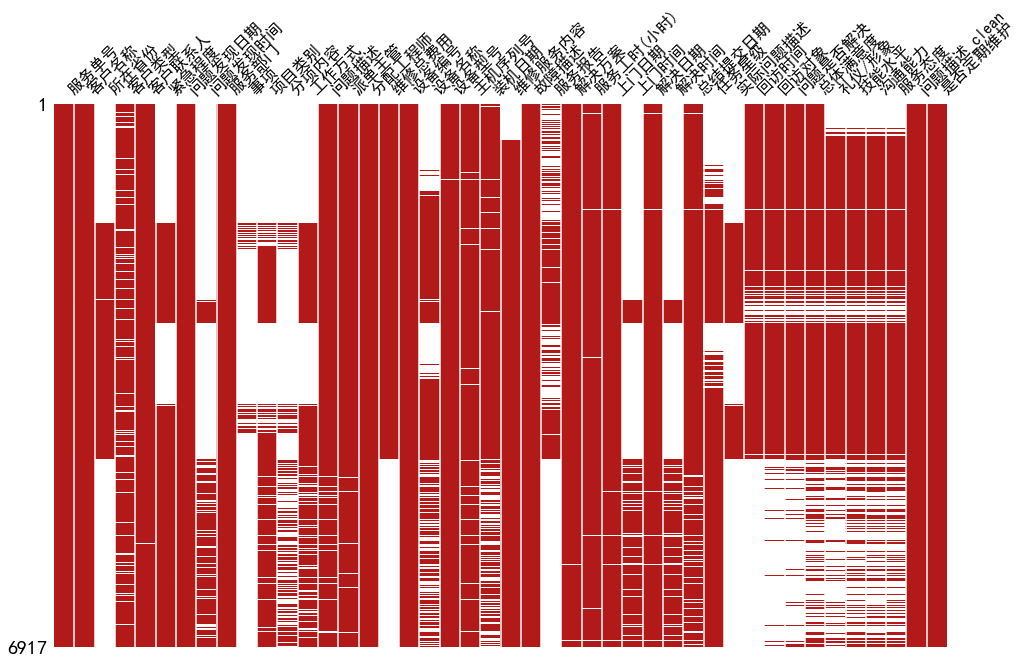

In [57]:
msno.matrix(data,figsize=(16, 10),color=(0.7, 0.1, 0.1),filter='bottom',sparkline=False)
# plt.savefig('{}NA_origin_eda.png'.format(config.savefig_path))

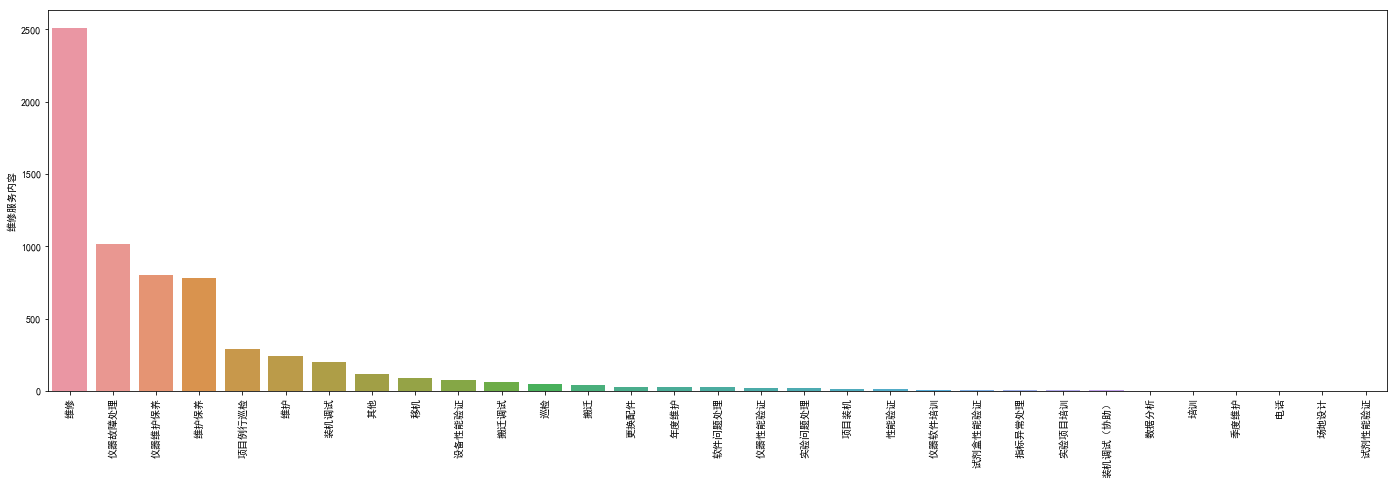

In [82]:
service_content = data['维修服务内容'].value_counts()
plt.figure(figsize = (24,7))
sns.barplot(service_content.index, service_content)
plt.xticks(rotation = 90)
plt.savefig('{}维修服务内容.png'.format(config.savefig_path))

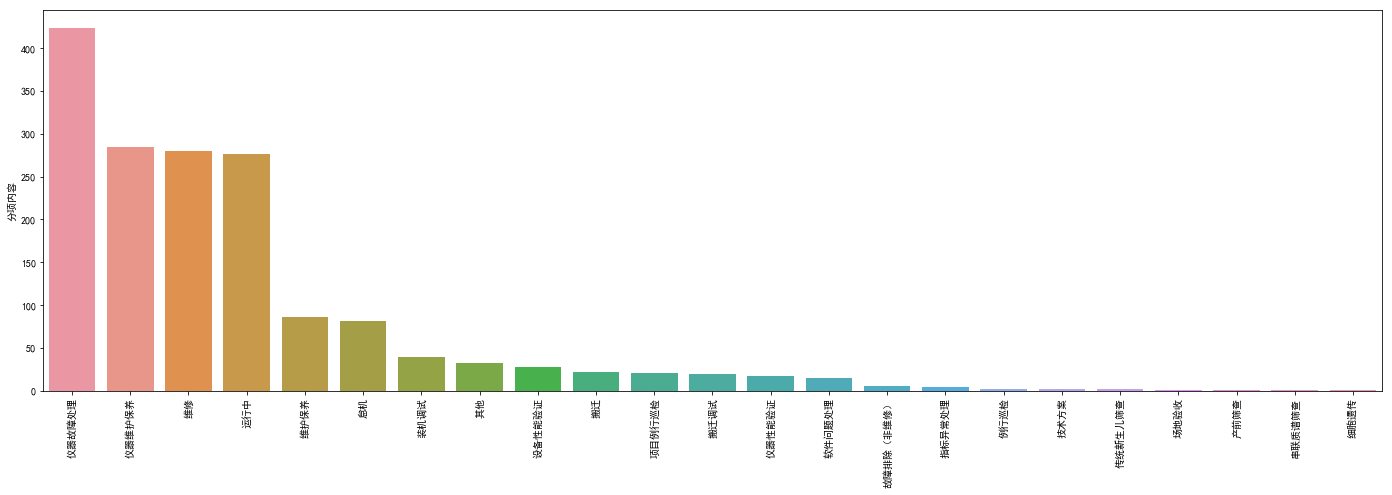

In [83]:
service_content = data['分项内容'].value_counts()
plt.figure(figsize = (24,7))
sns.barplot(service_content.index, service_content)
plt.xticks(rotation = 90)
plt.savefig('{}分项内容.png'.format(config.savefig_path))

In [98]:
data1['分配工程师'].value_counts()

宋挺     169
林正一    166
林栋     155
杨露鉴    140
王剑     135
黄玉立    127
徐琪枫    127
文立强    124
戴明路    113
王新震    101
徐睿超    100
傅菲菲     98
王强2     89
赵佳盛     88
潘盛      86
陈凌云     75
郑耀庭     33
吴挺      32
康迈      10
刘文久      9
Name: 分配工程师, dtype: int64

In [97]:
data1 = data.loc[data['实际问题描述'].notnull(),:].reset_index(drop = True)
for i in range(10):
    print(text_clean(data1['实际问题描述'][i]))

K和H装机以来，一直偶发性报serverBusy错误，两台质谱的工作站均为联想C30
K和H装机以来，一直偶发性报serverBusy错误，两台质谱的工作站均为联想C30
1.M52电脑，更换MassLynx版本为SCN8492.与质谱ping连接，发现原网卡故障，更换原C30网卡，建立质谱通讯3.配制Masslynx，上机测试发现响应只有600-700，无TIC图形，测试其他新筛板依旧如此4.怀疑电脑软件问题，网卡和GPIB卡装回到C30，联机重置质谱后，上机测试发现问题依旧5.清洗锥孔，并进PEG发现无任何特征峰出现，同时检查诊断界面，发现MS1RFGenerator振荡电压无法上升6.泄真空，重新插拔MS1RFGenerator相关线路，开机抽真空后，加压后问题依旧7.换回C30，并质谱断电重启，按此操作后问题依旧，基本断定为MS1RFGenerator故障；下礼拜一需报修Waters订购配件
1.操作系统及MassLynx及相关驱动安装好2.将WaterPumpControl更换为1.12.1218后，发现MSConsole打不开报错3.重装MassLynx解决，建立连接，复溶5块板测试，次日周一无报错；后续进行测试
图像重复（同一核型拍两次）拍出来白色图像更换灯泡
QuattroMicro仪器，今年6月份清洗过离子源后响应尚可，近期仪器响应不稳定，工程师上门维护一下，响应即能恢复，但实验人员平时维护后，响应又复下降，反复几次，怀疑仪器依然存在问题
机械泵漏油严重
加样针在板和洗针槽的位置偏；
120拍出来的核型总是往上偏
1235增强液黑色罩子掉落


In [60]:
pd.options.display.max_columns = 200

data.head(5)

,服务单号,客户名称,所在省份,客户类型,客户联系人,紧急程度,问题发现日期,问题发现时间,服务部门,事项,项目类别,分项内容,工作方式,问题描述,派单主管,分配工程师,维修总费用,设备编号,设备名称,设备型号,主机序列号,装机日期,维修服务内容,故障描述,服务报告,解决方案,服务工时(小时),上门日期,上门时间,解决日期,解决时间,总结提交日期,任务星级,实际问题描述,回访时间,回访对象,问题是否解决,总体满意度,礼仪/形象,技能水平,沟通能力,服务态度,问题描述_clean,是否定期维护
613,BS-SHFW-维修部201712053736,浙江大学医学院附属儿童医院,浙江省,V VIP,胡真真,正常,2016-06-30,NaN,维修部,NaN,串联质谱筛查,NaN,上门,K和H装机以来，一直偶发性报server&nbsp;Busy错误，两台质谱的工作站均为联想C30,傅菲菲,傅菲菲,0.0,BS-2016-WTS-TQD-16,串联质谱（Xevo TQD）,Xevo TQD,QCA1346,2016-10-08,维修,K和H装机以来，一直偶发性报server Busy错误，两台质谱的工作站均为联想C30,1.将K和H的C30工作站更换为联想P510\n<br>2.将两台2777&nbsp;fir...,1.陈险峰到实验室后检查发现2777所有firmware为2.4.0，故根据文件要求更新到2...,12.0,2017-12-04,NaN,2017-12-05,NaN,2017-12-05,二星,K和H装机以来，一直偶发性报server&nbsp;Busy错误，两台质谱的工作站均为联想C...,2017-12-15,胡真真,是,5,5,5,5,5,K和H装机以来，一直偶发性报serverBusy错误，两台质谱的工作站均为联想C30,False
615,BS-SHFW-维修部201712053736,浙江大学医学院附属儿童医院,浙江省,V VIP,胡真真,正常,2016-06-30,NaN,维修部,NaN,串联质谱筛查,NaN,上门,K和H装机以来，一直偶发性报server&nbsp;Busy错误，两台质谱的工作站均为联想C30,傅菲菲,傅菲菲,0.0,BS-2016-WTS-TQD-01,串联质谱（TQD）,TQD,QBC1852,2016-06-09,维修,K和H装机以来，一直偶发性报server Busy错误，两台质谱的工作站均为联想C30,1.将K和H的C30工作站更换为联想P510\n<br>2.将两台2777&nbsp;fir...,1.电脑更换为P510，安装MassLynx SCN849，出现could not dele...,12.0,2017-12-04,NaN,2017-12-05,NaN,2017-12-05,二星,K和H装机以来，一直偶发性报server&nbsp;Busy错误，两台质谱的工作站均为联想C...,2017-12-15,胡真真,是,5,5,5,5,5,K和H装机以来，一直偶发性报serverBusy错误，两台质谱的工作站均为联想C30,False
654,BS-SHFW-维修部201609110670,淮安市妇幼保健院,NaN,VIP,金鑫,NaN,2016-07-11,NaN,维修部,NaN,NaN,NaN,NaN,仪器联机时载物台不动，并且报failed&nbsp;to&nbsp;home&nbsp;sy...,戴明路,吴挺,0.0,BS-2014-LAK-GSL-08,NaN,GSL-120,400106,2014-12-26,NaN,客户反映，仪器联机时载物台不动，并且报failed to home system错误,NaN,到现场后插拔载物台插座，重启电脑与仪器，SLtest connect正常，但执行home命令...,8.0,2016-07-12,NaN,2016-07-12,NaN,2016-07-13,NaN,NaN,2016-11-18,金鑫,是,5,NaN,NaN,NaN,NaN,仪器联机时载物台不动，并且报failedtohomesystem错误,False
658,BS-SHFW-维修部201609110671,东南大学附属中大医院,NaN,VIP,黄桂英,NaN,2016-07-11,NaN,维修部,NaN,NaN,NaN,NaN,1、洗板机面板需要更换&nbsp;\n<br>2、1420需要维护,戴明路,吴挺,0.0,BS-2012-PKI-WS-01,NaN,1296-026,KC0J394807,2012-02-24,NaN,1、洗板机面板故障\n<br>2、1420需要维护,NaN,1、更换洗板机按键面板。 \n<br>2、1420常规维护。,4.0,2016-07-14,NaN,2016-07-14,NaN,2016-07-14,NaN,NaN,2016-10-10,黄桂英,是,5,NaN,NaN,NaN,NaN,1、洗板机面板需要更换2、1420需要维护,False
674,BS-SHFW-维修部201609110672,苏州市立医院（本部）,NaN,V+VIP,李琼,NaN,2016-07-14,NaN,维修部,NaN,NaN,NaN,NaN,1、最近一次新筛实验中，1235板处理器仪器无故报液体满。&nbsp;\n<br>2、历史记...,戴明路,吴挺,6342.0,BS-2009-PKI-AD-03,NaN,1235-514,"2351028,&nbsp;2970817",2009-04-03,NaN,1、最近一次新筛实验中，1235板处理器仪器无故报液体满。 \n<br>2、历史记录中有较多...,NaN,1、检查废液桶盖，发现桶盖两液面探针底部密封的白胶已脱落，当废液飞溅到盖上时，容易导致探针导...,4.0,2016-07-18,NaN,2016-07-18,NaN,2016-07-18,NaN,NaN,2016-11-18,李琼,是,5,NaN,NaN,NaN,NaN,1、最近一次新筛实验中，1235板处理器仪器无故报液体满。2、历史记录中有较多真空错误报错3...,False
